In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error,mean_squared_error
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!pip install scikit-learn==1.5.2

In [ ]:
df = pd.read_csv('/content/drive/My Drive/collab(data)/online_retail_sales_dataset.csv')

In [ ]:
df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,2023-01-01 00:00:00,1993,915,Home & Kitchen,8,103.30,0.23,Gift Card,27,Female,North America,636.33
1,2,2023-01-01 00:01:00,3474,553,Clothing,9,180.28,0.31,Gift Card,53,Other,South America,1119.54
2,3,2023-01-01 00:02:00,4564,248,Beauty & Personal Care,7,81.58,0.27,Debit Card,34,Other,North America,416.87
3,4,2023-01-01 00:03:00,1133,948,Clothing,3,235.20,0.00,Debit Card,50,Other,Australia,705.60
4,5,2023-01-01 00:04:00,3626,284,Books,9,453.00,0.34,Credit Card,23,Female,Australia,2690.82


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  int64  
 1   timestamp          1000000 non-null  object 
 2   customer_id        1000000 non-null  int64  
 3   product_id         1000000 non-null  int64  
 4   product_category   1000000 non-null  object 
 5   quantity           1000000 non-null  int64  
 6   price              1000000 non-null  float64
 7   discount           1000000 non-null  float64
 8   payment_method     1000000 non-null  object 
 9   customer_age       1000000 non-null  int64  
 10  customer_gender    1000000 non-null  object 
 11  customer_location  1000000 non-null  object 
 12  total_amount       1000000 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 99.2+ MB


In [ ]:
df.describe()

,transaction_id,customer_id,product_id,quantity,price,discount,customer_age,total_amount
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,2998.854163,549.804766,5.003086,252.445705,0.250204,43.508625,946.839858
std,288675.278933,1154.764311,259.848068,2.581004,142.868633,0.144384,15.007346,810.902205
min,1.000000,1000.000000,100.000000,1.000000,5.000000,0.000000,18.000000,2.560000
25%,250000.750000,1999.000000,325.000000,3.000000,128.690000,0.130000,31.000000,297.180000
50%,500000.500000,2999.000000,550.000000,5.000000,252.700000,0.250000,44.000000,715.710000
75%,750000.250000,3998.000000,775.000000,7.000000,375.990000,0.380000,57.000000,1397.750000
max,1000000.000000,4999.000000,999.000000,9.000000,500.000000,0.500000,69.000000,4496.130000


In [ ]:
df = df[df['timestamp']<'2024-01-01 00:00:00']

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

## **Preprocessing & Visualization**

In [ ]:
df_category_daily = df.groupby([pd.Grouper(key='timestamp', freq='D'), 'product_category'])['quantity'].sum().reset_index()

In [ ]:
df_category_daily.set_index('timestamp', inplace=True)

In [ ]:
df_category_daily.tail(10)

,product_category,quantity
timestamp,,
2023-12-30,Clothing,1253
2023-12-30,Electronics,1083
2023-12-30,Home & Kitchen,1303
2023-12-30,Sports & Outdoors,1286
2023-12-31,Beauty & Personal Care,1248
2023-12-31,Books,1164
2023-12-31,Clothing,1170
2023-12-31,Electronics,1331
2023-12-31,Home & Kitchen,1150


In [ ]:
df_category_total = df_category_daily.groupby('product_category')['quantity'].sum().reset_index()

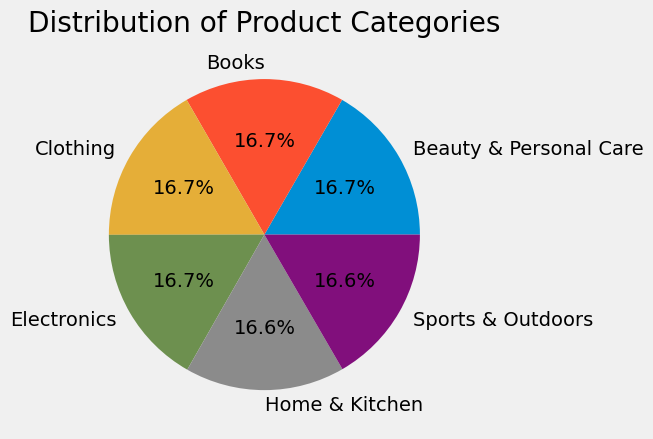

In [ ]:
plt.pie(df_category_total['quantity'], labels=df_category_total['product_category'], autopct='%1.1f%%')
plt.title('Distribution of Product Categories')
plt.show()

In [ ]:
start_date = '2023-01-01'
end_date = '2023-01-31'
df_january = df_category_daily.loc[start_date:end_date]

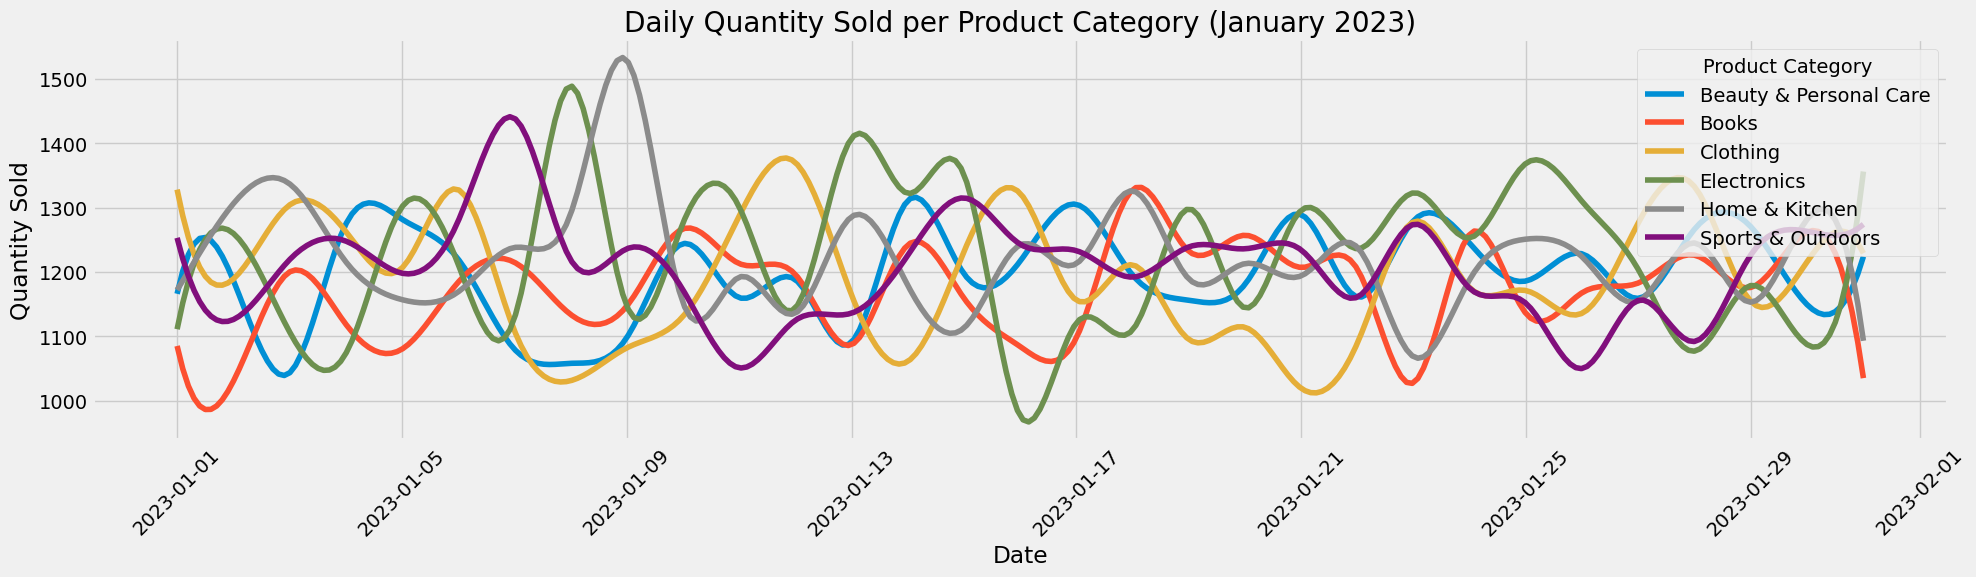

In [ ]:
from scipy.interpolate import make_interp_spline
import matplotlib.dates as mdates

plt.figure(figsize=(20, 6))


for category in df_january['product_category'].unique():
    category_data = df_january[df_january['product_category'] == category]
    x = category_data.index
    y = category_data['quantity']
    x_smooth = pd.date_range(start=x.min(), end=x.max(), periods=300)
    spline = make_interp_spline(mdates.date2num(x), y, k=3)
    y_smooth = spline(mdates.date2num(x_smooth))
    plt.plot(x_smooth, y_smooth, label=category)
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title('Daily Quantity Sold per Product Category (January 2023)')
plt.legend(title='Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_category_semi_monthly = df.groupby([pd.Grouper(key='timestamp', freq='SME'), 'product_category'])['quantity'].sum().reset_index()

In [ ]:
df_category_semi_monthly['timestamp'] = pd.to_datetime(df_category_semi_monthly['timestamp'])

In [ ]:
df_category_semi_monthly.set_index('timestamp', inplace=True)

In [ ]:
start_date = '2022-12-31'
end_date = '2023-12-15'
df_yearly = df_category_semi_monthly[(df_category_semi_monthly.index >= start_date) & (df_category_semi_monthly.index <= end_date)]

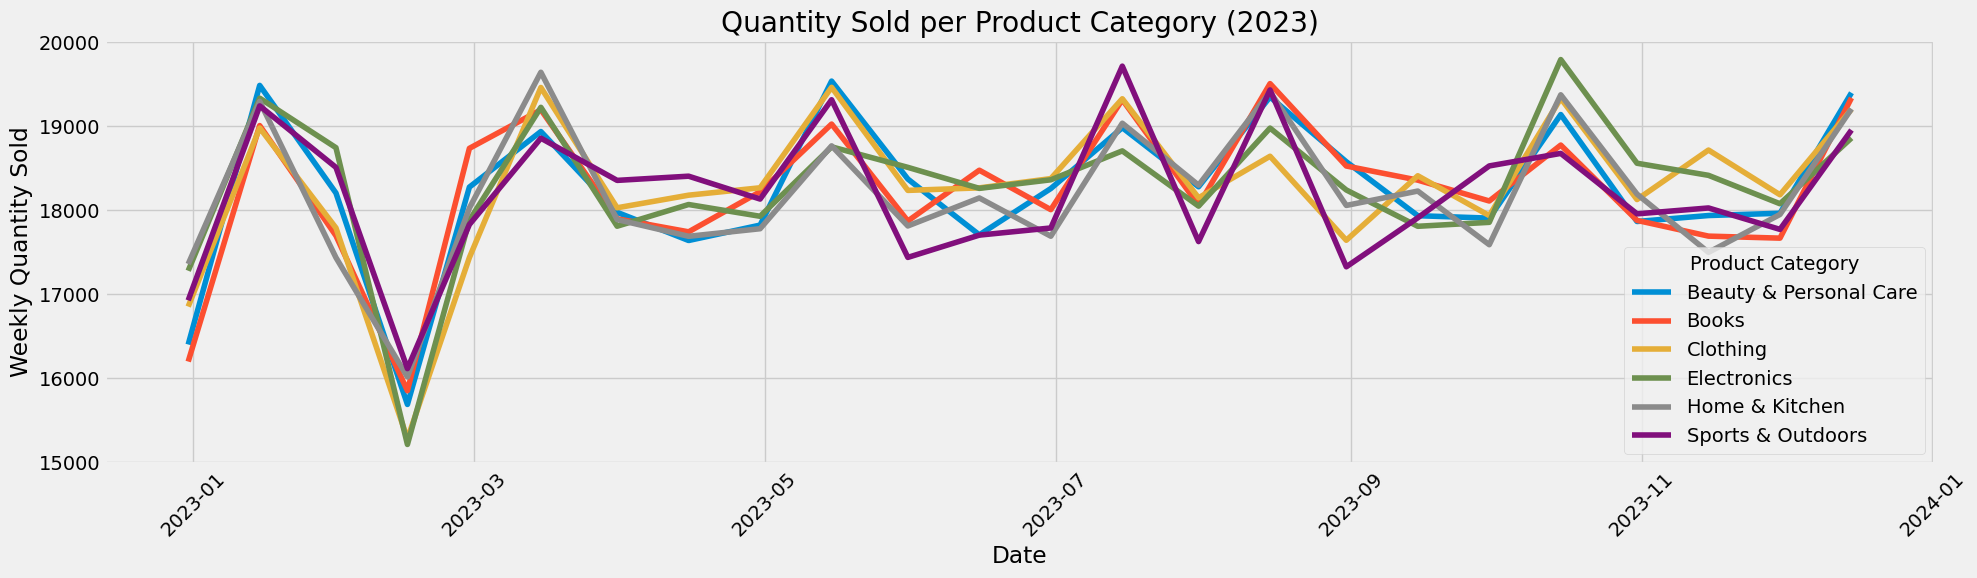

In [ ]:
plt.figure(figsize=(20, 6))
for category in df_yearly['product_category'].unique():
    category_data = df_yearly[df_yearly['product_category'] == category]
    plt.plot(category_data.index, category_data['quantity'], label=category)

plt.xlabel('Date')
plt.ylabel('Weekly Quantity Sold')
plt.title('Quantity Sold per Product Category (2023)')
plt.legend(title='Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

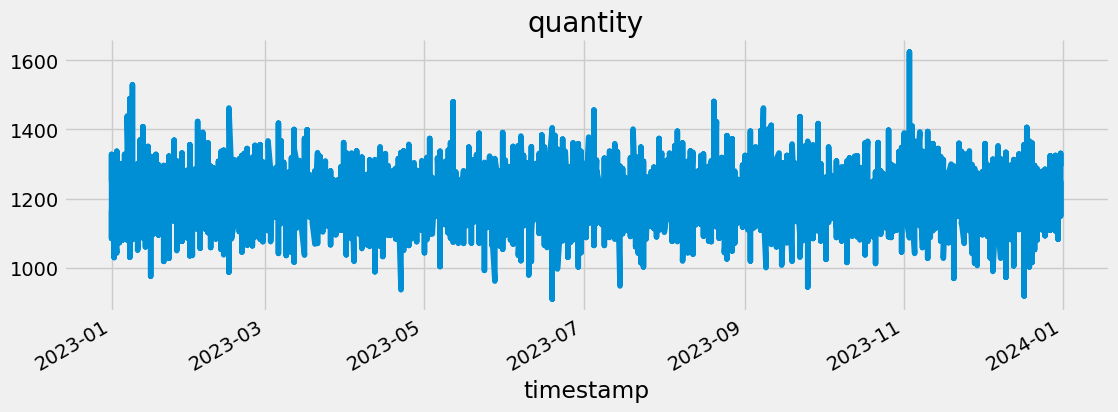

In [ ]:
df_category_daily['quantity'].plot(kind='line', figsize=(12, 4), title='quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df_category_daily.tail(10)

,product_category,quantity
timestamp,,
2023-12-30,Clothing,1253
2023-12-30,Electronics,1083
2023-12-30,Home & Kitchen,1303
2023-12-30,Sports & Outdoors,1286
2023-12-31,Beauty & Personal Care,1248
2023-12-31,Books,1164
2023-12-31,Clothing,1170
2023-12-31,Electronics,1331
2023-12-31,Home & Kitchen,1150


## **Sample Data**

In [ ]:
time_index = df.set_index('timestamp')

In [ ]:
categorical_data = time_index[time_index['product_category'] == 'Sports & Outdoors']

In [ ]:
sample_data = time_index.resample('D')['quantity'].sum()

In [ ]:
sample_data.tail(10)

,quantity
timestamp,
2023-12-22,7125
2023-12-23,7148
2023-12-24,7213
2023-12-25,7148
2023-12-26,7163
2023-12-27,7211
2023-12-28,7092
2023-12-29,7267
2023-12-30,7426


## **Features**

In [ ]:
sample_data = sample_data.to_frame(name='quantity')

sample_data['lag_1'] = sample_data['quantity'].shift(1)
sample_data['lag_2'] = sample_data['quantity'].shift(2)
sample_data['lag_3'] = sample_data['quantity'].shift(3)

sample_data['diff_1'] = sample_data['quantity'].diff(1)
sample_data['diff_2'] = sample_data['quantity'].diff(2)

sample_data['month'] = sample_data.index.month
sample_data['day'] = sample_data.index.day

sample_data['rolling_mean_10'] = sample_data['quantity'].rolling(window=10).mean()

In [ ]:
sample_data.head()

,quantity,lag_1,lag_2,lag_3,diff_1,diff_2,month,day,rolling_mean_10
timestamp,,,,,,,,,
2023-01-01,7115,NaN,NaN,NaN,NaN,NaN,1,1,NaN
2023-01-02,7098,7115.0,NaN,NaN,-17.0,NaN,1,2,NaN
2023-01-03,7210,7098.0,7115.0,NaN,112.0,95.0,1,3,NaN
2023-01-04,7193,7210.0,7098.0,7115.0,-17.0,95.0,1,4,NaN
2023-01-05,7224,7193.0,7210.0,7098.0,31.0,14.0,1,5,NaN


## **Train-Test Splitting**

In [ ]:
train_size = int(len(sample_data) * 0.8)
train_set = sample_data.iloc[:train_size]
test_set = sample_data.iloc[train_size:]

print(f'Training set size: {len(train_set)}')
print(f'Test set size: {len(test_set)}')

Training set size: 292
Test set size: 73


In [ ]:
X_train = train_set.drop(columns=['quantity'])
y_train = train_set['quantity']

X_test = test_set.drop(columns=['quantity'])
y_test = test_set['quantity']

## **RandomForestRegressor**

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
rf_pred = rf_model.predict(X_test)

In [ ]:
rf_mae = mean_absolute_error(y_test, rf_pred)
print(f'Random Forest MAE: {rf_mae:.2f}')
rf_mse = mean_squared_error(y_test, rf_pred)
print(f'Random Forest MSE: {rf_mse:.2f}')

Random Forest MAE: 20.45
Random Forest MSE: 793.81


In [ ]:
results_rf = pd.DataFrame({
    'Date': y_test.index,
    'Actual': y_test.values,
    'Predicted': rf_pred
})

In [ ]:
results_rf

,Date,Actual,Predicted
0,2023-10-20,7153,7170.13
1,2023-10-21,7133,7149.81
2,2023-10-22,7278,7272.11
3,2023-10-23,7224,7208.07
4,2023-10-24,7278,7268.90
...,...,...,...
68,2023-12-27,7211,7220.17
69,2023-12-28,7092,7094.63
70,2023-12-29,7267,7251.92
71,2023-12-30,7426,7346.60


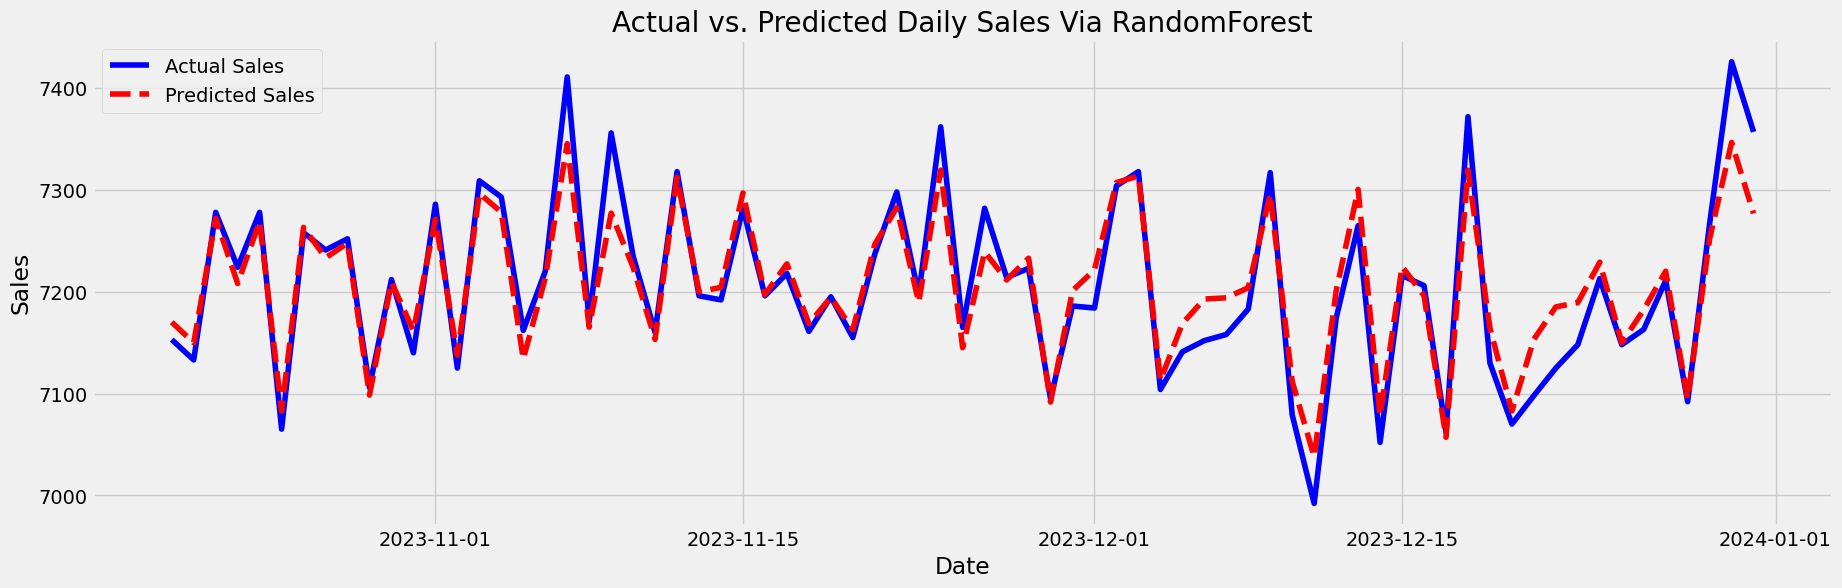

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(results_rf['Date'], results_rf['Actual'], label='Actual Sales', color='blue')
plt.plot(results_rf['Date'], results_rf['Predicted'], label='Predicted Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Daily Sales Via RandomForest')
plt.legend()
plt.show()

## **XGBoost**

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_pred = xgb_model.predict(X_test)

In [ ]:
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f'XGBR MAE: {xgb_mae:.2f}')
xgb_mse = mean_squared_error(y_test, rf_pred)
print(f'XGBR MSE: {xgb_mse:.2f}')

XGBR MAE: 17.18
XGBR MSE: 793.81


In [ ]:
results_xgb = pd.DataFrame({
    'Date': y_test.index,
    'Actual': y_test.values,
    'Predicted': xgb_pred
})

In [ ]:
results_xgb

,Date,Actual,Predicted
0,2023-10-20,7153,7143.810547
1,2023-10-21,7133,7148.132812
2,2023-10-22,7278,7277.437500
3,2023-10-23,7224,7207.279785
4,2023-10-24,7278,7290.584961
...,...,...,...
68,2023-12-27,7211,7214.649414
69,2023-12-28,7092,7080.734375
70,2023-12-29,7267,7271.085938
71,2023-12-30,7426,7360.892578


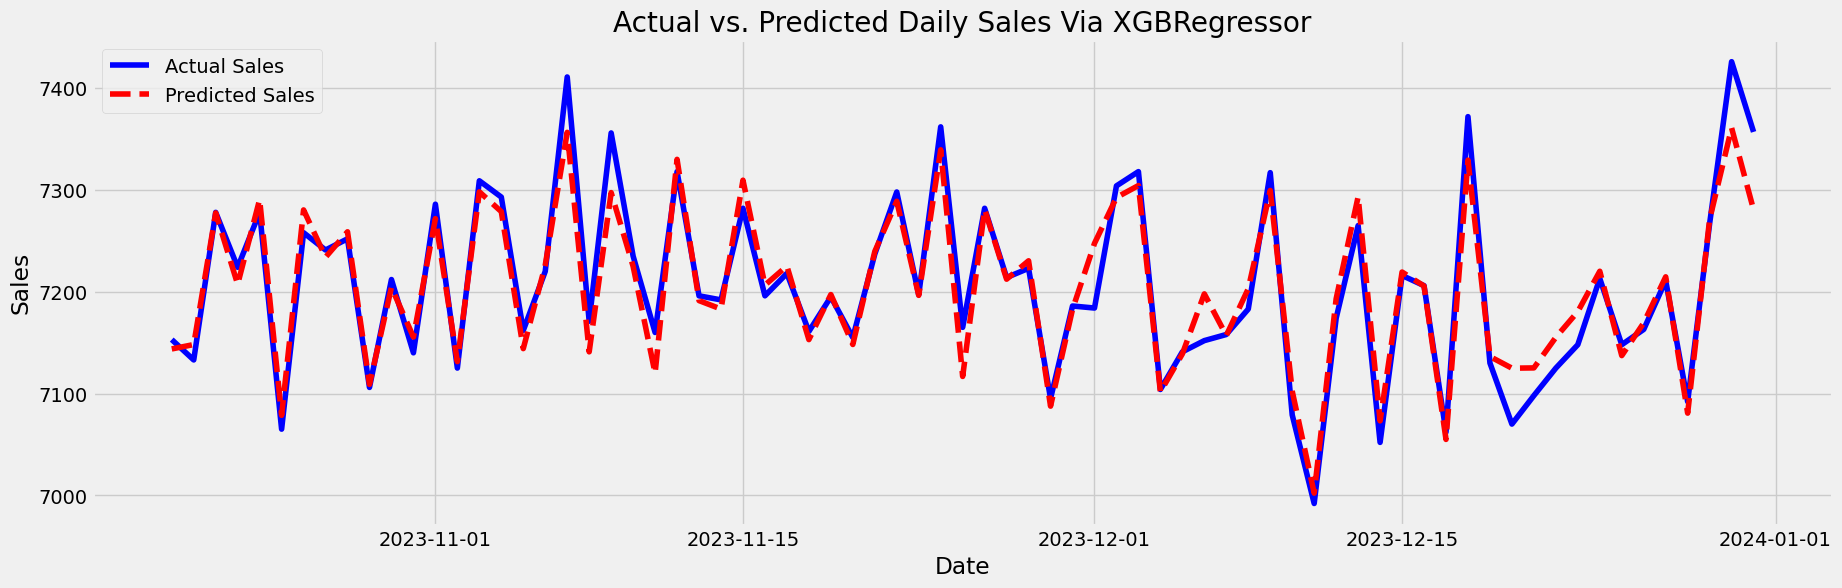

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(results_xgb['Date'], results_xgb['Actual'], label='Actual Sales', color='blue')
plt.plot(results_xgb['Date'], results_xgb['Predicted'], label='Predicted Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Daily Sales Via XGBRegressor')
plt.legend()
plt.show()


## **LGBMRegressor**

In [ ]:
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
lgbm_model.fit(X_train, y_train)

LGBMRegressor(random_state=42, verbose=-1)

In [ ]:
lgbm_pred = lgbm_model.predict(X_test)

In [ ]:
lgbm_mae = mean_absolute_error(y_test, lgbm_pred)
print(f'LGBMRegressor MAE: {lgbm_mae:.2f}')

lgbm_mse = mean_squared_error(y_test, lgbm_pred)
print(f'LGBMRegressor MSE: {lgbm_mse:.2f}')

LGBMRegressor MAE: 15.51
LGBMRegressor MSE: 467.47


In [ ]:
results_lgbm = pd.DataFrame({
    'Date': y_test.index,
    'Actual': y_test.values,
    'Predicted': lgbm_pred
})

In [ ]:
results_lgbm

,Date,Actual,Predicted
0,2023-10-20,7153,7149.323527
1,2023-10-21,7133,7127.853919
2,2023-10-22,7278,7266.206604
3,2023-10-23,7224,7216.585672
4,2023-10-24,7278,7277.838787
...,...,...,...
68,2023-12-27,7211,7183.033320
69,2023-12-28,7092,7094.596238
70,2023-12-29,7267,7249.298377
71,2023-12-30,7426,7343.931267


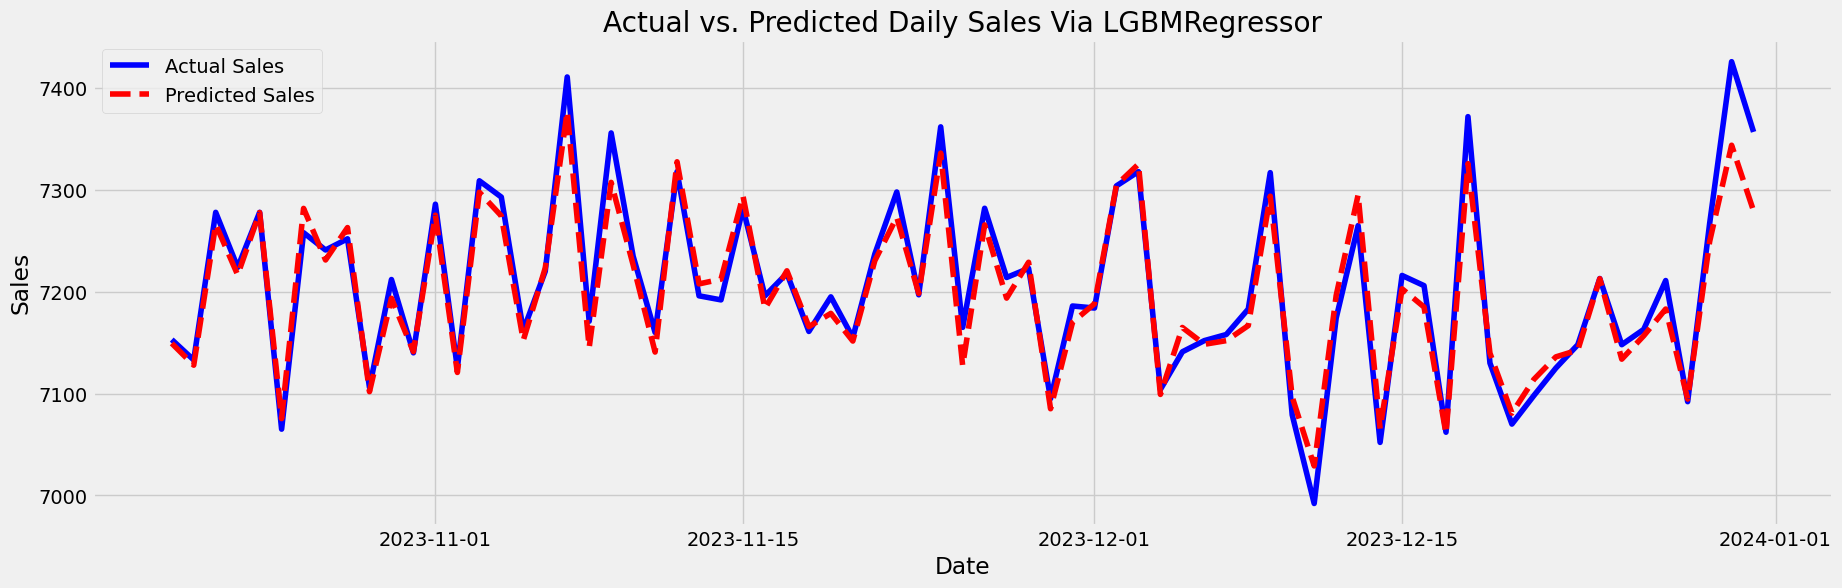

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(results_lgbm['Date'], results_lgbm['Actual'], label='Actual Sales', color='blue')
plt.plot(results_lgbm['Date'], results_lgbm['Predicted'], label='Predicted Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Daily Sales Via LGBMRegressor')
plt.legend()
plt.show()

## **Stacking**

In [ ]:
base_models = [
    ('rf', rf_model),
    ('lgbm', lgbm_model),
    ('xgb', xgb_model)
]

In [ ]:
meta_model = Ridge(alpha=1.0)

In [ ]:
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

In [ ]:
stacked_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('lgbm',
                               LGBMRegressor(random_state=42, verbose=-1)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_typ...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=Ridge())

In [ ]:
stacked_predictions = stacked_model.predict(X_test)

In [ ]:
stacked_mae = mean_absolute_error(y_test, stacked_predictions)
print(f'Stacked Model MAE: {stacked_mae:.2f}')
stacked_mse = mean_squared_error(y_test, stacked_predictions)
print(f'Stacked Model MSE: {stacked_mse:.2f}')

Stacked Model MAE: 14.50
Stacked Model MSE: 391.30


In [ ]:
results_stack = pd.DataFrame({
    'Date': y_test.index,
    'Actual': y_test.values,
    'Predicted': stacked_predictions
})

In [ ]:
results_stack

,Date,Actual,Predicted
0,2023-10-20,7153,7150.237308
1,2023-10-21,7133,7130.420249
2,2023-10-22,7278,7274.265041
3,2023-10-23,7224,7214.531716
4,2023-10-24,7278,7283.046277
...,...,...,...
68,2023-12-27,7211,7195.269361
69,2023-12-28,7092,7084.742540
70,2023-12-29,7267,7256.403051
71,2023-12-30,7426,7357.877941


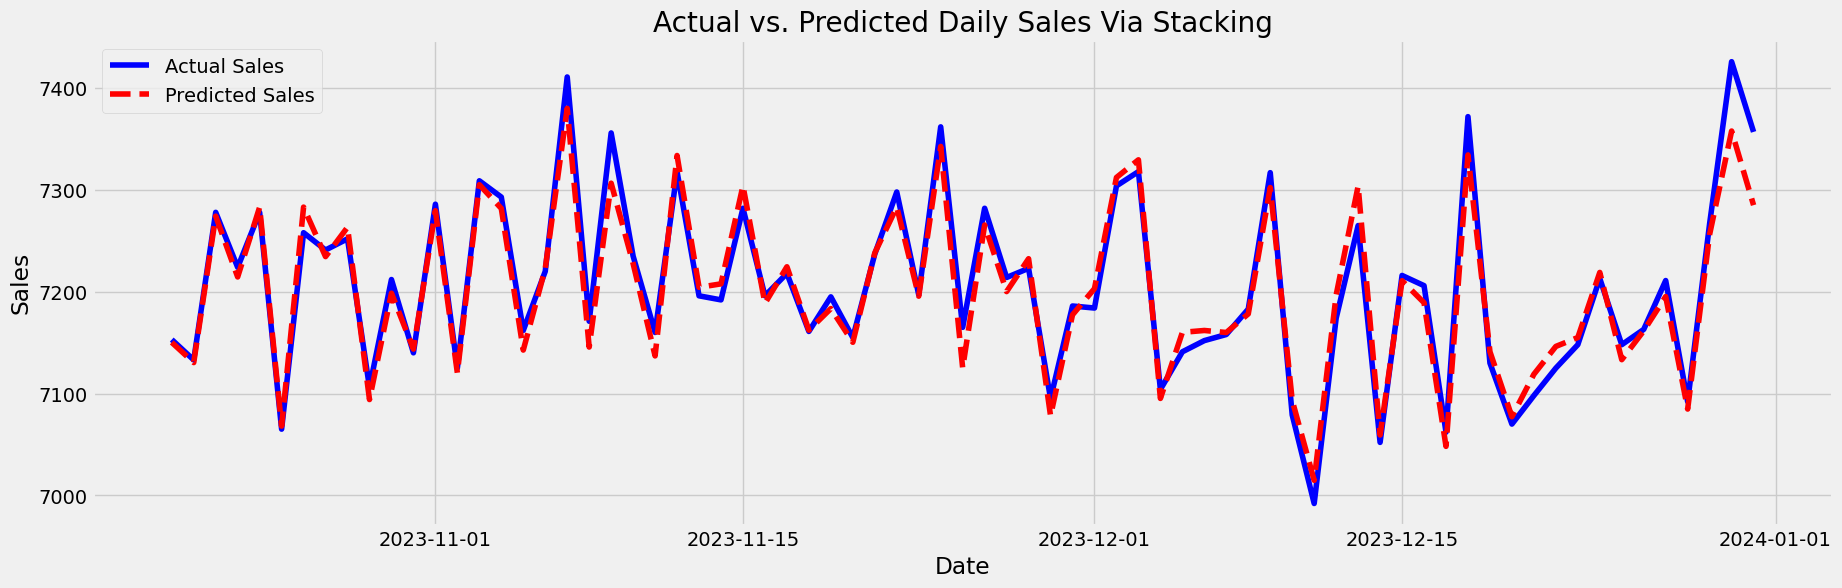

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(results_stack['Date'], results_stack['Actual'], label='Actual Sales', color='blue')
plt.plot(results_stack['Date'], results_stack['Predicted'], label='Predicted Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Daily Sales Via Stacking')
plt.legend()
plt.show()

## **Forecasting**

In [ ]:
forecast_periods = 30 #days

In [ ]:
forecast_data = sample_data.copy()

In [ ]:
forecast_data

,quantity,lag_1,lag_2,lag_3,diff_1,diff_2,month,day,rolling_mean_10
timestamp,,,,,,,,,
2023-01-01,7115,NaN,NaN,NaN,NaN,NaN,1,1,NaN
2023-01-02,7098,7115.0,NaN,NaN,-17.0,NaN,1,2,NaN
2023-01-03,7210,7098.0,7115.0,NaN,112.0,95.0,1,3,NaN
2023-01-04,7193,7210.0,7098.0,7115.0,-17.0,95.0,1,4,NaN
2023-01-05,7224,7193.0,7210.0,7098.0,31.0,14.0,1,5,NaN
...,...,...,...,...,...,...,...,...,...
2023-12-27,7211,7163.0,7148.0,7213.0,48.0,63.0,12,27,7167.8
2023-12-28,7092,7211.0,7163.0,7148.0,-119.0,-71.0,12,28,7139.8
2023-12-29,7267,7092.0,7211.0,7163.0,175.0,56.0,12,29,7153.5


In [ ]:
for i in range(forecast_periods):
  last_row = forecast_data.iloc[-1]
  next_date = last_row.name + pd.DateOffset(days=1)

  new_row = {
      'lag_1': last_row['quantity'],
      'lag_2': forecast_data.iloc[-2]['quantity'] if len(forecast_data) >= 2 else None,
      'lag_3': forecast_data.iloc[-3]['quantity'] if len(forecast_data) >= 3 else None,
      'diff_1': last_row['quantity'] - forecast_data.iloc[-2]['quantity'] if len(forecast_data) >= 2 else None,
      'diff_2': last_row['quantity'] - forecast_data.iloc[-3]['quantity'] if len(forecast_data) >= 3 else None,
      'month': next_date.month,
      'day': next_date.day,
      'rolling_mean_10': forecast_data['quantity'].iloc[-10:].mean() if len(forecast_data) >= 10 else None,
  }
  new_row_df = pd.DataFrame([new_row])
  forecasted_quantity = stacked_model.predict(new_row_df)[0]
  forecast_data = pd.concat([forecast_data, pd.DataFrame({'quantity': [forecasted_quantity]}, index=[next_date])])

In [ ]:
forecasted_values = forecast_data[-forecast_periods:]['quantity']

In [ ]:
print("Forecasted Values for the next ", forecast_periods, " days:")
print(forecasted_values)

Forecasted Values for the next  30  days:
2024-01-01    7288.993668
2024-01-02    7189.286675
2024-01-03    7098.777339
2024-01-04    7033.497864
2024-01-05    7038.017401
2024-01-06    7118.214568
2024-01-07    7192.098754
2024-01-08    7262.465477
2024-01-09    7325.902610
2024-01-10    7350.110608
2024-01-11    7339.086222
2024-01-12    7317.494944
2024-01-13    7288.880165
2024-01-14    7267.017575
2024-01-15    7246.970081
2024-01-16    7235.936700
2024-01-17    7210.566811
2024-01-18    7206.394909
2024-01-19    7204.607675
2024-01-20    7226.313346
2024-01-21    7238.822563
2024-01-22    7267.526573
2024-01-23    7298.083888
2024-01-24    7328.002211
2024-01-25    7346.135206
2024-01-26    7350.560642
2024-01-27    7340.707740
2024-01-28    7321.287329
2024-01-29    7292.364159
2024-01-30    7272.949988
Name: quantity, dtype: float64
